In [1]:
import tensorflow as tf
from absl import flags, app

from tensorflow.keras import layers, models, optimizers

import numpy as np
import pandas as pd
import os
import math
import uuid
from tqdm import tqdm
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from matplotlib import pyplot as plt
import seaborn as sns
from yaw_pred import * 

import cv2
from PIL import Image

## Define paths for the data 

Camera information + 8 total bins was used to caculate yaw

In [2]:
NUM_BINS = 8
IMAGE_INP_SIZE = 64

content_dir = os.path.abspath('H:\Data_Science_Masters\\third_sem_documents\Learning For Images\project\yaw_prediction')

PATH_DATAFRAME = "/generated_train_updated_v2/data.csv"
PATH_IMGS =  os.path.abspath(content_dir+"/generated_train_updated_v2/img/")

## Load and calculate angles to create bins
Process data

In [8]:
dataset = pd.read_csv(f"{content_dir}/{PATH_DATAFRAME}").drop('Unnamed: 0', axis=1)
dataset['Name'] = dataset.apply(lambda r: PATH_IMGS +'\\'+ r['Name'] +'.jpg', axis=1)

# Get global angle expressed in [0, 2π] range
dataset['Global_angle'] = dataset.apply(lambda r: to_angle(r['Global']), axis=1)

# Get ray angle expressed in [0, 2π] range
dataset['Ray_Angle_angle'] = dataset.apply(lambda r: to_angle(r['Ray_Angle']), axis=1)

# Calculate Local rotation
dataset['Local'] = dataset['Global_angle'] - dataset['Ray_Angle_angle']

# Correct the local angle in case the substraction is < 0 (express it in range 0,2π)
dataset['Local_corrected'] = dataset.apply(lambda r: to_angle(r['Local']), axis=1)

# Get Bins + Offsets
dataset[['Bin_nb', 'Bin_offset']] = dataset.apply(lambda r: pd.Series(get_bin(r['Local_corrected'])), axis=1)
dataset['Bin_nb'] = dataset['Bin_nb'].astype('int')

#Normalize bin offset
max_off = dataset['Bin_offset'].max()
dataset['Bin_offset_norm'] = dataset['Bin_offset'] / max_off # if max_off > 1 else dataset['Bin_offset']
dataset.head()

,Name,Global,Ray_Angle,Local,Global_angle,Ray_Angle_angle,Local_corrected,Bin_nb,Bin_offset,Bin_offset_norm
0,H:\Data_Science_Masters\third_sem_documents\Le...,-0.017174,0.063197,6.202814,6.266011,0.063197,6.202814,0,0.312328,0.397676
1,H:\Data_Science_Masters\third_sem_documents\Le...,-0.064356,0.324735,5.894095,6.218830,0.324735,5.894095,0,0.003608,0.004594
2,H:\Data_Science_Masters\third_sem_documents\Le...,-0.074954,0.256578,5.951654,6.208231,0.256578,5.951654,0,0.061167,0.077882
3,H:\Data_Science_Masters\third_sem_documents\Le...,0.045236,-0.013152,-6.224798,0.045236,6.270033,0.058387,0,0.451086,0.574353
4,H:\Data_Science_Masters\third_sem_documents\Le...,-0.070631,0.024188,6.188366,6.212555,0.024188,6.188366,0,0.297880,0.379280


### See the distributions of bins

D:\Applications\Anaconda\envs\lfi\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


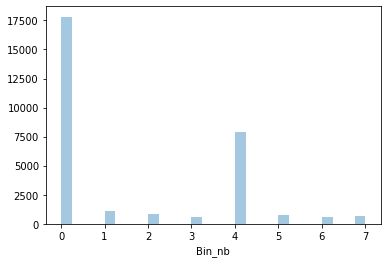

In [5]:
# Imbalanced plot
sns.distplot(dataset['Bin_nb'], kde=False)

The dataset is pretty unbalanced, so in order to mitigate (a little bit) that, intentional bias was introduced towards the underrepresented classes

In [14]:
# Balance bin number to reduce (as much as possible) biases. Cars in 0/4 (facing frontwards/backwards) are the majority
bins0 = dataset.loc[dataset['Bin_nb'] == 0].head(5000)
bins4 = dataset.loc[dataset['Bin_nb'] == 4].head(5000)
others = dataset.loc[(dataset['Bin_nb'] != 0) & (dataset['Bin_nb'] != 4)]

# Over represent the classes
new_dataset_rows = [bins0, bins4]
new_dataset_rows.extend([others] * 10)

dataset = pd.concat(new_dataset_rows).sample(frac=1)
dataset

,Name,Global,Ray_Angle,Local,Global_angle,Ray_Angle_angle,Local_corrected,Bin_nb,Bin_offset,Bin_offset_norm
5475,H:\Data_Science_Masters\third_sem_documents\Le...,3.124740,-0.077166,-3.081279,3.124740,6.206019,3.201906,4,0.453013,0.576806
4167,H:\Data_Science_Masters\third_sem_documents\Le...,-0.739164,0.012424,5.531597,5.544021,0.012424,5.531597,7,0.426509,0.543060
8541,H:\Data_Science_Masters\third_sem_documents\Le...,-0.304005,0.159461,5.819719,5.979180,0.159461,5.819719,7,0.714631,0.909915
24511,H:\Data_Science_Masters\third_sem_documents\Le...,-2.797120,-0.286195,-2.510925,3.486065,5.996991,3.772260,5,0.237968,0.302997
12632,H:\Data_Science_Masters\third_sem_documents\Le...,0.459113,-0.008050,-5.816022,0.459113,6.275135,0.467163,1,0.074464,0.094812
...,...,...,...,...,...,...,...,...,...,...
2892,H:\Data_Science_Masters\third_sem_documents\Le...,-0.290688,0.346173,5.646324,5.992497,0.346173,5.646324,7,0.541236,0.689137
22652,H:\Data_Science_Masters\third_sem_documents\Le...,-0.753853,-0.031324,-0.722529,5.529332,6.251861,5.560657,7,0.455568,0.580060
17853,H:\Data_Science_Masters\third_sem_documents\Le...,1.534030,0.313346,1.220684,1.534030,0.313346,1.220684,2,0.042587,0.054225
18842,H:\Data_Science_Masters\third_sem_documents\Le...,-0.765190,0.212792,5.305203,5.517995,0.212792,5.305203,7,0.200115,0.254799


Distribution of bins after introdcing bias successfully

D:\Applications\Anaconda\envs\lfi\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Applications\Anaconda\envs\lfi\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Bin_offset_norm')

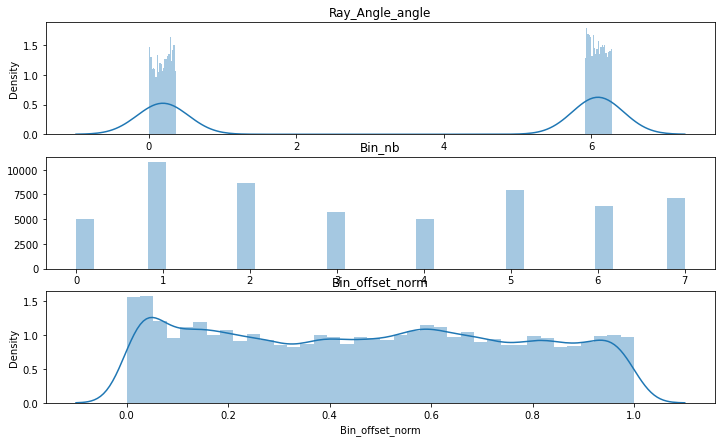

In [7]:
fig, ax = plt.subplots(3, figsize=(12,7))

sns.distplot(dataset['Ray_Angle_angle'], ax=ax[0], bins=360)
ax[0].set_title("Ray_Angle_angle")

sns.distplot(dataset['Bin_nb'], ax=ax[1], kde=False)
ax[1].set_title("Bin_nb")

sns.distplot(dataset['Bin_offset_norm'], ax=ax[2])
ax[2].set_title("Bin_offset_norm")

## Split data

In [17]:
# Train / Validation / Test split
train_mask = np.random.rand(len(dataset)) < 0.8

df_train = dataset[train_mask]
df_test = dataset[~train_mask]

valid_mask = np.random.rand(len(df_train)) < 0.1
df_val = df_train[valid_mask]
df_train = df_train[~valid_mask]
df_train

,Name,Global,Ray_Angle,Local,Global_angle,Ray_Angle_angle,Local_corrected,Bin_nb,Bin_offset,Bin_offset_norm
4167,H:\Data_Science_Masters\third_sem_documents\Le...,-0.739164,0.012424,5.531597,5.544021,0.012424,5.531597,7,0.426509,0.543060
8541,H:\Data_Science_Masters\third_sem_documents\Le...,-0.304005,0.159461,5.819719,5.979180,0.159461,5.819719,7,0.714631,0.909915
24511,H:\Data_Science_Masters\third_sem_documents\Le...,-2.797120,-0.286195,-2.510925,3.486065,5.996991,3.772260,5,0.237968,0.302997
12632,H:\Data_Science_Masters\third_sem_documents\Le...,0.459113,-0.008050,-5.816022,0.459113,6.275135,0.467163,1,0.074464,0.094812
18653,H:\Data_Science_Masters\third_sem_documents\Le...,2.000420,0.035296,1.965124,2.000420,0.035296,1.965124,3,0.001628,0.002074
...,...,...,...,...,...,...,...,...,...,...
4757,H:\Data_Science_Masters\third_sem_documents\Le...,-0.489804,0.269117,5.524264,5.793381,0.269117,5.524264,7,0.419176,0.533723
26623,H:\Data_Science_Masters\third_sem_documents\Le...,1.467370,-0.180154,-4.635662,1.467370,6.103032,1.647524,2,0.469427,0.597705
22652,H:\Data_Science_Masters\third_sem_documents\Le...,-0.753853,-0.031324,-0.722529,5.529332,6.251861,5.560657,7,0.455568,0.580060
17853,H:\Data_Science_Masters\third_sem_documents\Le...,1.534030,0.313346,1.220684,1.534030,0.313346,1.220684,2,0.042587,0.054225


**TF.Data conversion for speed**

In [ ]:
def proc_image(path, bin_nb, offset):
    """Returns resized image with a set of bin_nb and offset.
    Parameters:
        - path, bin_nb, offset
    """    
    image = tf.io.read_file(path)
    oh_bin = tf.one_hot(bin_nb, NUM_BINS)

    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize the image to the desired size.
    image = tf.image.resize(image, [IMAGE_INP_SIZE, IMAGE_INP_SIZE])
    print(image, (oh_bin, offset))
    return image, (oh_bin, offset)


In [19]:
### Training data
dataset = tf.data.Dataset.from_tensor_slices((df_train['Name'].values, df_train['Bin_nb'].values, df_train['Bin_offset_norm'].values))
dataset = dataset.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(8).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Validation data
dataset_valid = tf.data.Dataset.from_tensor_slices((df_val['Name'].values, df_val['Bin_nb'].values, df_val['Bin_offset_norm'].values))
dataset_valid = dataset_valid.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.batch(8).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

steps_per_epoch_train = len(df_train) // 8
validation_steps = len(df_val) // 8

### Test data
data_test = tf.data.Dataset.from_tensor_slices((df_test['Name'].values, df_test['Bin_nb'].values, df_test['Bin_offset_norm'].values))
data_test = data_test.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test = data_test.batch(8).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

steps_per_epoch_test = len(df_test) // 8

Tensor("resize/Squeeze:0", shape=(64, 64, 1), dtype=float32) (<tf.Tensor 'one_hot:0' shape=(8,) dtype=float32>, <tf.Tensor 'args_2:0' shape=() dtype=float64>)
Tensor("resize/Squeeze:0", shape=(64, 64, 1), dtype=float32) (<tf.Tensor 'one_hot:0' shape=(8,) dtype=float32>, <tf.Tensor 'args_2:0' shape=() dtype=float64>)


## Create Model
Simple ResNet approach was used. The speed must be a requirement for a Autonomous driving application.

In [24]:
def res_block(previous):
    conv1 = layers.Conv2D(256, (1,1), activation='relu', kernel_regularizer='l2', padding='same')(previous)
    conv2 = layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer='l2', padding='same')(conv1)
    conv3 = layers.Conv2D(128, (1,1), activation='relu', kernel_regularizer='l2', padding='same')(conv2)
    concat = layers.Concatenate()([previous, conv3])
    concat = layers.BatchNormalization()(concat)
    return concat

inp = layers.Input(shape=(IMAGE_INP_SIZE,IMAGE_INP_SIZE,1))
conv1 = layers.Conv2D(128, (4,4), activation='relu', strides=2)(inp)
pool1 = layers.MaxPool2D()(conv1)
block1 = res_block(pool1)
pool2 = layers.MaxPool2D((2,2))(block1)
block2 = res_block(pool2)
pool3 = layers.MaxPool2D((2,2))(block2)


flat = layers.Flatten()(pool3)
model_output = layers.Dense(500, activation='linear')(flat)

out_offset = layers.Dense(500, activation='relu')(model_output)
out_offset = layers.Dropout(.2)(out_offset)
out_offset = layers.Dense(300, activation='linear')(out_offset)
out_offset = layers.Dense(1, activation='sigmoid', name='out_offset')(out_offset)

out_bin = layers.Dense(500, activation='relu')(model_output)
out_bin = layers.Dropout(.2)(out_bin)
out_bin = layers.Dense(200, activation='linear')(out_bin)
out_bin = layers.Dense(NUM_BINS, activation='softmax', name='out_bin')(out_bin)


model = models.Model(inputs=[inp], outputs=[out_bin, out_offset])

callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(monitor='val_out_bin_acc', patience=2, min_delta=0.001, mode='max', restore_best_weights=True)
]

metrics = {
    'out_bin': ['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
}

model.compile(optimizers.Adam(lr=1e-4), loss=['categorical_crossentropy', 'mse'], loss_weights=[0.5, 0.5], 
              metrics=metrics)

In [25]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 31, 31, 128)  2176        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 15, 15, 128)  0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 15, 15, 256)  33024       max_pooling2d_3[0][0]            
_______________________________________________________________________________________

## Train Model

In [26]:
hist = model.fit(dataset,
                 epochs = 20,
                 callbacks = callbacks,
                 steps_per_epoch=steps_per_epoch_train, 
                 validation_data=dataset_valid, 
                 validation_steps=validation_steps)

Epoch 1/20
5096/5096 [==============================] - 390s 76ms/step - loss: 3.7583 - out_bin_loss: 1.7060 - out_offset_loss: 0.0939 - out_bin_acc: 0.3740 - out_bin_precision_1: 0.5833 - out_bin_recall_1: 0.1430 - val_loss: 1.1459 - val_out_bin_loss: 1.2631 - val_out_offset_loss: 0.0810 - val_out_bin_acc: 0.5458 - val_out_bin_precision_1: 0.7502 - val_out_bin_recall_1: 0.3425
Epoch 2/20
5096/5096 [==============================] - 400s 78ms/step - loss: 0.7576 - out_bin_loss: 0.9985 - out_offset_loss: 0.0704 - out_bin_acc: 0.6448 - out_bin_precision_1: 0.7889 - out_bin_recall_1: 0.4921 - val_loss: 0.5725 - val_out_bin_loss: 0.8390 - val_out_offset_loss: 0.0620 - val_out_bin_acc: 0.7046 - val_out_bin_precision_1: 0.8105 - val_out_bin_recall_1: 0.6013
Epoch 3/20
5096/5096 [==============================] - 413s 81ms/step - loss: 0.4016 - out_bin_loss: 0.5598 - out_offset_loss: 0.0497 - out_bin_acc: 0.8101 - out_bin_precision_1: 0.8723 - out_bin_recall_1: 0.7433 - val_loss: 0.3266 - val

## Plot Training Summary

Text(0.5, 0.98, 'Train history')

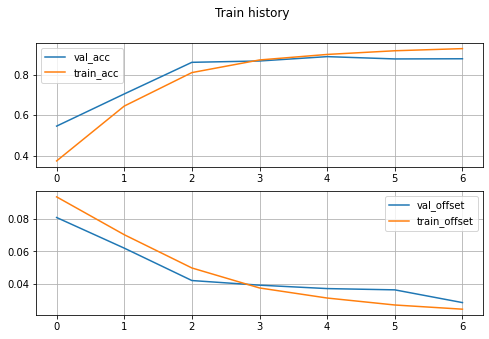

In [27]:
fig, ax = plt.subplots(2, figsize=(8,5))
ax[0].plot(hist.history['val_out_bin_acc'], label='val_acc')
ax[0].plot(hist.history['out_bin_acc'], label='train_acc')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(hist.history['val_out_offset_loss'], label='val_offset')
ax[1].plot(hist.history['out_offset_loss'], label='train_offset')
ax[1].grid(True)
ax[1].legend()

fig.suptitle("Train history")

**Prediction on Test set**

In [28]:
test_results = model.predict(data_test, steps=steps_per_epoch_test, verbose=True)

1409/1409 [==============================] - 26s 19ms/step


In [30]:
#Denormalize offset 
test_results[1] *= max_off

Predict example

Real offset: 0.5932281513741567
Real bin: 4
REAL ANGLE 174.45820016599896
------------------------------
Predicted bin: 4
Predicted offset: [0.49519753]
PREDICTED ANGLE 168.84147032039314


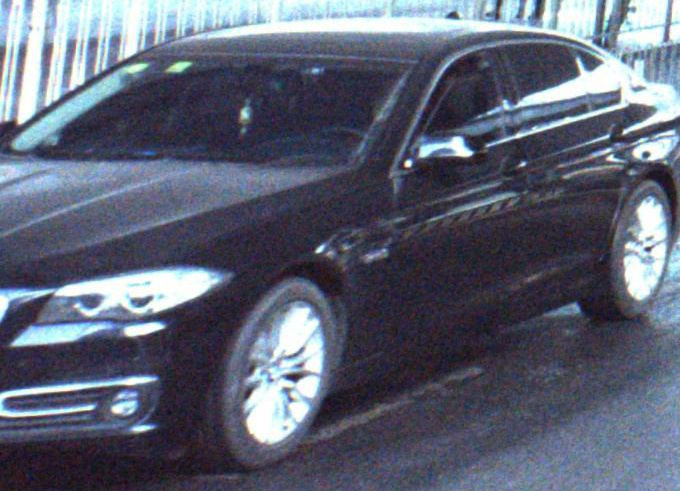

In [31]:
index = 29
image = Image.open(df_test.iloc[index]['Name'])
p_off = test_results[1][index]
p_bin = test_results[0][index]

real_off = df_test.iloc[index]['Bin_offset']
real_bin = df_test.iloc[index]['Bin_nb']


print(f"Real offset: {real_off}")
print(f"Real bin: {real_bin}")
print(f"REAL ANGLE {math.degrees(df_test.iloc[index]['Global_angle'])}")

print("-"*30)
bin_nb = np.argmax(p_bin)
offset = p_off
ray_angle = df_test.iloc[index]['Ray_Angle']

print(f"Predicted bin: {bin_nb}")
print(f"Predicted offset: {offset}")
print(f"PREDICTED ANGLE {math.degrees(prediction_to_yaw(bin_nb, offset, ray_angle)[0])}")

display(image)

### Evaluate the model with the global (ground truth) angles on Test set

In [33]:
#### Iterate through all prediction

pred_angles = []
real_angles = []

real_bins = []
predicted_bins = []

for i in range(len(test_results[1])):
    p_off = test_results[1][i]
    p_bin = test_results[0][i]
    ray_angle = df_test.iloc[i]['Ray_Angle']
    
    bin_nb = np.argmax(p_bin)
    offset = p_off
    
    ang = math.degrees(prediction_to_yaw(bin_nb, offset, ray_angle)[0])
    
    pred_angles.append(ang)
    real_angles.append(math.degrees(df_test.iloc[i]['Global_angle']))
    
    real_bins.append(df_test.iloc[i]['Bin_nb'])
    predicted_bins.append(bin_nb)

Confussion matrix of the bins

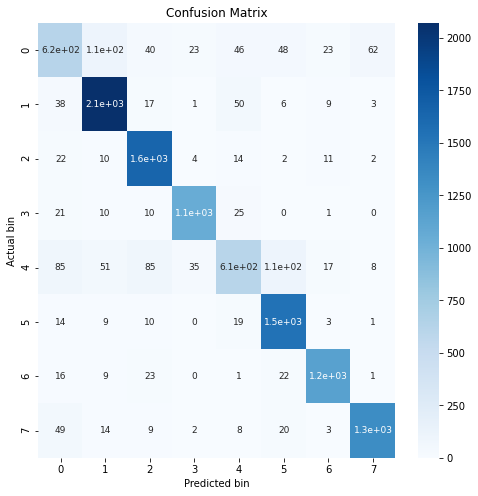

In [34]:
cm = confusion_matrix(real_bins, predicted_bins)
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Confusion Matrix')
sns.heatmap(cm, cmap="Blues", annot=True, ax=ax, annot_kws={"size": 9})
ax.set_ylabel('Actual bin')
ax.set_xlabel('Predicted bin');

In [36]:
precision, recall, fscore, support = score(real_bins, predicted_bins)
eval_df = pd.DataFrame({"Bin_nb":[0,1,2,3,4,5,6,7],
        "Precision":precision,
        "Recall":recall,
        "F1score":fscore}) 
eval_df

,Bin_nb,Precision,Recall,F1score
0,0,0.717090,0.636270,0.674267
1,1,0.905553,0.943508,0.924141
2,2,0.894622,0.962033,0.927104
3,3,0.942119,0.940444,0.941281
4,4,0.789406,0.608566,0.687289
5,5,0.880069,0.964934,0.920550
6,6,0.945037,0.941176,0.943103
7,7,0.945429,0.927033,0.936140


## Error Distribution Of difference between actual and predicted angles

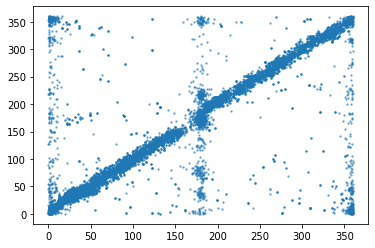

In [35]:
fig, ax = plt.subplots(1)
ax.scatter(real_angles, pred_angles, alpha=0.5, s=2);

The above plots show that the model is biased because of the data. This is normal as most of the cars are placed on two directions (frontwards/backwards).

Calculate the error distribution.

In [37]:
errors = [angle_distance(a1, a2) for a1,a2 in zip(pred_angles, real_angles)]

D:\Applications\Anaconda\envs\lfi\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Avg. error: 15.666627798611707
Median error: -1.067952929796931
Max. error: 179.95205006354496
SD error: 35.5617411882321


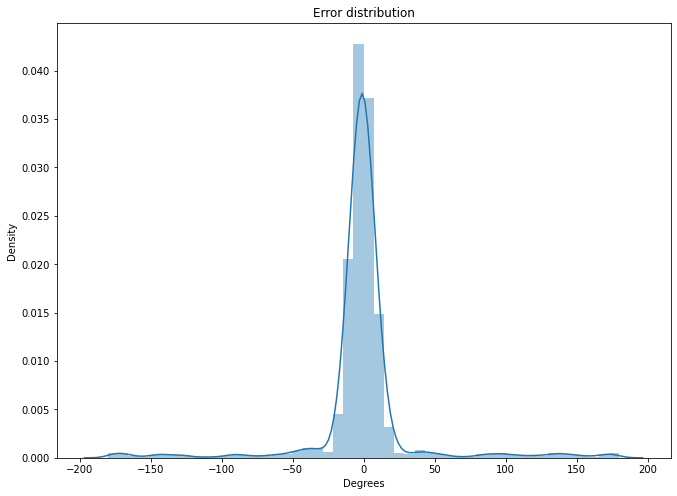

In [38]:
fig, ax = plt.subplots(1, figsize=(11,8))
sns.distplot(errors, ax=ax)
ax.set_title("Error distribution")
ax.set_xlabel("Degrees")

print(f"Avg. error: {np.mean(np.abs(errors))}")
print(f"Median error: {np.median(errors)}")
print(f"Max. error: {np.max(np.abs(errors))}")
print(f"SD error: {np.std(errors)}")

## Save model

In [39]:
model.save('trained_models\yaw.h5')